# Traffic Sign Classifier


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import math
import time

import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

from pylab import *

# Load pickled data
import pickle


---
## Step 0: Load The Data

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
training_file = "../TrafficSignClassifier/traffic-signs-data/train.p"
validation_file = "../TrafficSignClassifier/traffic-signs-data/valid.p"
testing_file = "../TrafficSignClassifier/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

In [3]:
# Number of training examples
n_train =  X_train.shape[0]

# Number of validation examples
n_validation = X_validation.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of training examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("All unique classes: ", np.unique(y_train))


Number of training examples = 34799
Number of training examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
All unique classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


## Data Preprocessing Functions

In [4]:
def gray(images):
    """
    Convert all images from RGB to gray using average of R, G, B values
    images shape: (n x w x l x 1)
    output shape: (n x w x l x 1)
    """
    gray = np.average(images, axis=3)
    gray = np.expand_dims(gray, axis=3)
    return gray

def normalize(images, m=128, s=128):
    """
    Normalize each image in the set images
    """
    #X = images.astype('float32')
    X = np.array(images, dtype=np.float32)
    
    out = (X - m) / s
    return out

def preprocess(images, grayscale=True):
    """
    """
    if grayscale:
        images = gray(images)
        
    nimages = normalize(images)
    return nimages
    

---

## Step 1: Dataset Summary & Exploration




### Include an exploratory visualization of the dataset

In [5]:
examplepath = ("examples_output/")
if not os.path.isdir(examplepath): os.makedirs(examplepath)

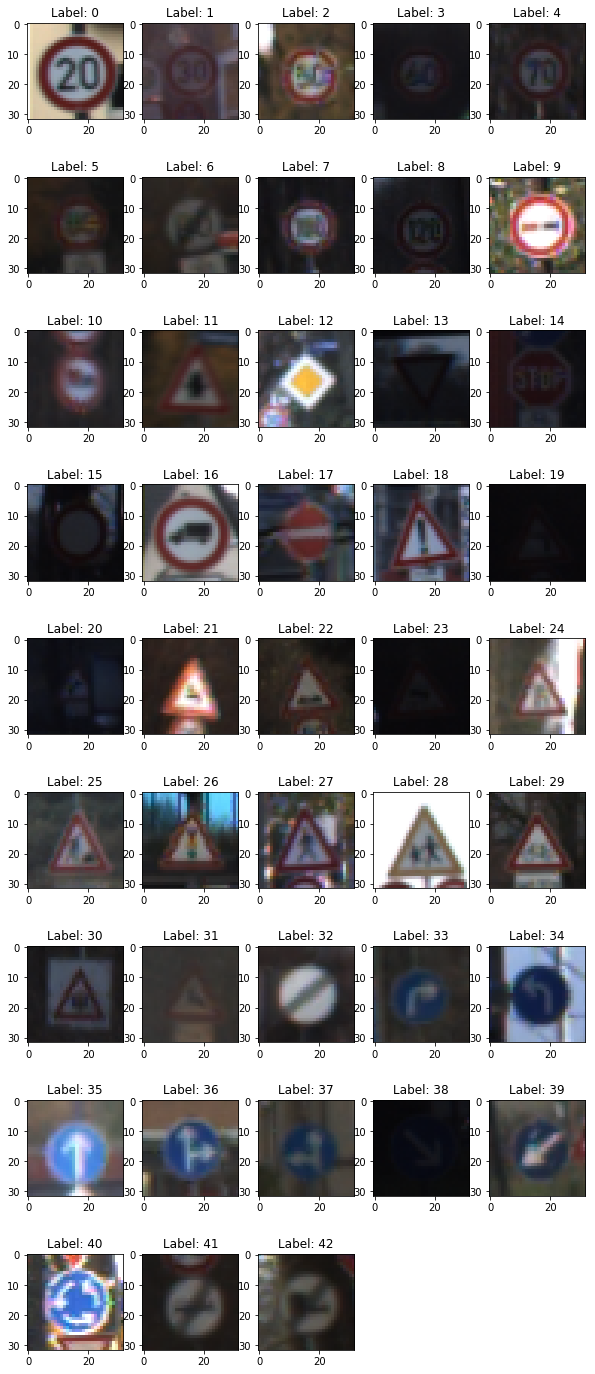

In [6]:
## Plot each unique value
u, idxu = np.unique(y_train, return_index=True)
nimage = len(idxu)

simages = X_train[idxu,]
slabs = y_train[idxu]
plt.rcParams["figure.figsize"] = (10,25)
for i, image in enumerate(simages):
    plt.subplot(math.ceil(nimage/5), 5, i+1)
    plt.imshow(image)
    plt.title('Label: %d' % slabs[i])
    
plt.savefig(os.path.join(examplepath, "1_AllClasses.png"), dpi=600)

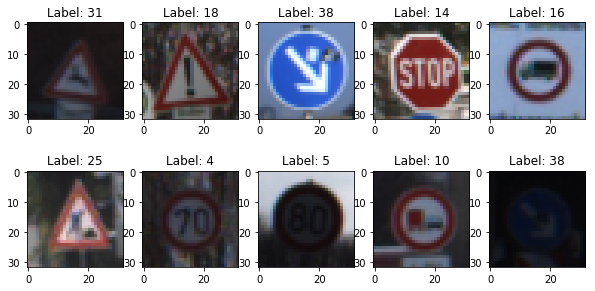

In [7]:
nimage = 10
select = np.random.randint(0, n_train, nimage)
simages = X_train[select,]
slabs = y_train[select]

plt.rcParams["figure.figsize"] = (10,5)

for i, image in enumerate(simages):
    plt.subplot(math.ceil(nimage/5), 5, i+1)
    plt.imshow(image)
    plt.title('Label: %d' % slabs[i])
    
plt.savefig(os.path.join(examplepath, "2_Rand10images.png"), dpi=600)

Text(0.5,0.98,'Label: 18')

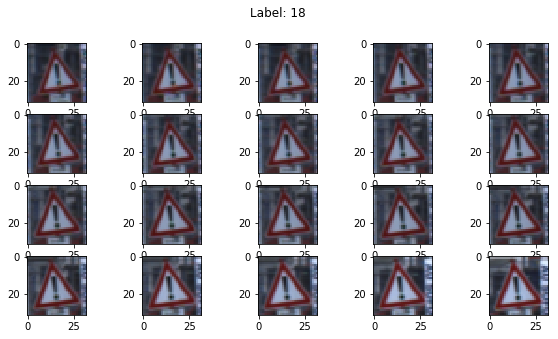

In [8]:
## Assess the difference within one class to have a sense of the model complexity needed
selab = 18
sel2, = np.where(y_train==selab)
nims = sel2.shape[0]
if nims > 20: sel2 = sel2[0:20]
simages2 = X_train[sel2]
slabs2 = y_train[sel2]
plt.rcParams["figure.figsize"] = (10,5)
fig = gcf()
for i, image in enumerate(simages2):
    plt.subplot(math.ceil(sel2.shape[0]/5), 5, i+1)
    plt.imshow(image)
fig.suptitle("Label: "+ str(selab))


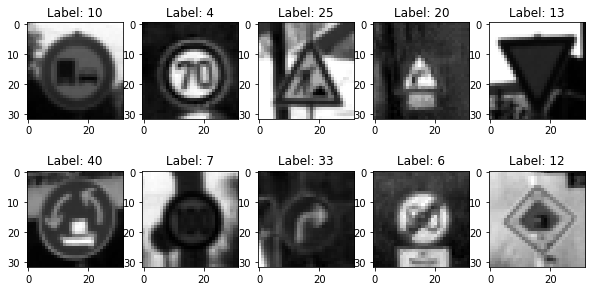

In [9]:
# Check grayscaling and normalization
nimage = 10
select = np.random.randint(0, n_train, nimage)
simages = X_train[select]
simages = gray(simages,)
timages = normalize(simages)
slabs = y_train[select]
plt.rcParams["figure.figsize"] = (10,5)

for i, image in enumerate(simages):
    plt.subplot(math.ceil(nimage/5), 5, i+1)
    image = image.squeeze()
    plt.imshow(image, cmap='gray')
    plt.title('Label: %d' % slabs[i])

### Distribution Histogram

True
True


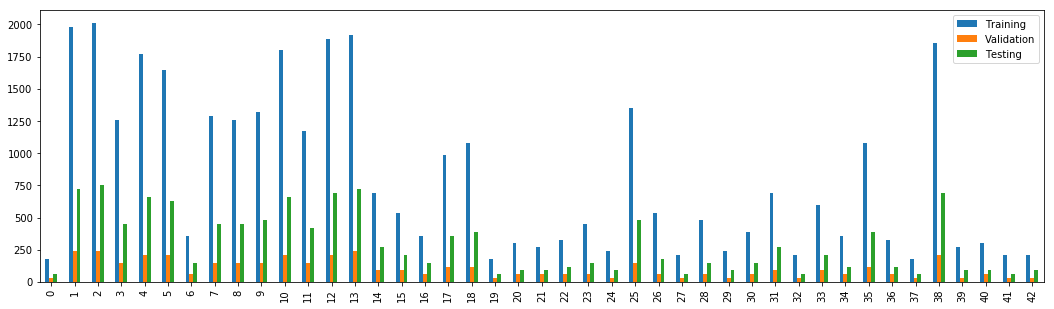

In [10]:

c_tr, nc_tr = np.unique(y_train, return_counts=True)
c_va, nc_va = np.unique(y_validation, return_counts=True)
c_te, nc_te = np.unique(y_test, return_counts=True)

print((c_tr == c_te).all())
print((c_te == c_va).all())

df2 = pd.DataFrame(np.column_stack((nc_tr, nc_va, nc_te)),
                   columns=['Training', 'Validation', 'Testing'])

plt.rcParams["figure.figsize"] = (18,5)
fig1 = df2.plot.bar();
plt.savefig(os.path.join(examplepath, "3_SampleDistribution.png"), dpi=600)

The sample of sign is not balanced, but some signs are more representative then others. However this representativenes proportion is kept among training, validation and testing sample. 

As the sample is not uniformly distributed abong the classes it is possible that for some classes we can achieve better prediction than for other classes. As proportions of signs among training, validation and testing samples are relatively constant, we can expect the performance of between training, validation and between training and testing not being biased by sample selection

----

## Step 2: Design and Test a Model Architecture



The model architecture is based on the LeNet. An additional convolutional layer is added to it and itcan takes 3 channels as input for RGB images

### Input
The architecture accepts a 32x32xC image as input, where C is the number of color channels. If grayscale Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.**  Input = 32x32xnchannel. Output = 28x28x9.

**Activation.** Relu

**Max Pooling.** Input = 28x28x9. Output = 14x14x9.

**Layer 2: Convolutional.** Input = 14x14x9. Output = 12x12x27.

**Activation.** Relu

**Layer 3: Convolutional.** 12x12x27. Output = 9x9x81.

**Activation.** Relu

**Max Pooling.** Input = 9x9x81. Output = (3x3x81) 

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.
Input = 3x3x81. Output = (729x1) 

**Layer 4: Fully Connected.** This should have int(729/2.5) = 291 outputs.

**Activation.** Relu

**Layer 5: Fully Connected.** This should have int(291/2.5) = 116 outputs.

**Activation.** Relu

**Layer 6: Fully Connected (Logits).** This should have n_classes = 43 outputs.

### Output
Logits: the result of the Layer 6.

In [11]:
from tensorflow.contrib.layers import flatten

### Model Architecture
def MyNet1(x, nclasses, nchannel):
    """
    Architectire of the neural network,
    Augment the LeNet architecture with additional layer and allow nchannel as input.
    Logit is array of nchannel
    """
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    # hyperparameters for weight initialization
    mu = 0
    sigma = 0.1
    
    ###############################
    # Layer 1: Convolutional. Input = 32x32xnchannel. Output = 28x28x9.
    # (32- 5 +1)/1 = 28 
    # Modification, allow possibility for 3 channel RGB data 
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, nchannel, 9), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(9))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x9. Output = 14x14x9
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    ###############################
    # Layer 2: Convolutional.  Input =  14x14x9. Output = 12x12x27.
    # (14-3+1)/1 = 12
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 9, 27), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(27))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    ###############################
    # Add: Layer 3. Convolution, input 12x12x27, output:  12-4+1 = 9x9x81
    conv3_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 27, 81), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(81))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Add Activation
    conv3 = tf.nn.relu(conv3)
    
    # Add max Pooling: input = 9x9x81, output = (3x3x81) 
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='VALID')
    
    ###############################
    # Flatten. Input =3x3x81. Output = 729
    fc0   = flatten(conv3)
    
    fcdim = 729
    nflattenlayer = 1
    while (fcdim > (3*nclasses)):     
        # Layer 3+: Fully Connected. Input = 729. Output = nclasses.
        fcdim2 = int(fcdim/2.5) 
        fc1_W = tf.Variable(tf.truncated_normal(shape=(fcdim, fcdim2), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(fcdim2))
        fc0   = tf.matmul(fc0, fc1_W) + fc1_b
        # Activation
        fc0    = tf.nn.relu(fc0)
        fcdim =  fcdim2 
        nflattenlayer = nflattenlayer +1 

#     # Layer 4: Fully Connected. Input = 729. Output = 290.
#     fc1_W = tf.Variable(tf.truncated_normal(shape=(729, 290), mean = mu, stddev = sigma))
#     fc1_b = tf.Variable(tf.zeros(290))
#     fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
#     # Activation.
#     fc1    = tf.nn.relu(fc1)

#     # Layer 5: Fully Connected. Input = 290. Output = 110.
#     fc2_W  = tf.Variable(tf.truncated_normal(shape=(290, 110), mean = mu, stddev = sigma))
#     fc2_b  = tf.Variable(tf.zeros(84))
#     fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
#     # Activation.
#     fc2    = tf.nn.relu(fc2)
        
    # Last 6: Fully Connected. Input = 110. Output = nClasses
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(fcdim, nclasses), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(nclasses))
    logits = tf.matmul(fc0, fc3_W) + fc3_b
    print( "Number of full connections layer is ", nflattenlayer)
        
    
    return logits

## Global Settings

In [12]:
EPOCHS = 40
BATCH_SIZE = 256 # training images each time in the network
img_size = 32  # square image of size IMG_SIZE x IMG_SIZE
grayscale = False  # convert image to grayscale?
nchannel = 1 if grayscale else 3

SAVE = True
OUT_PATH = ("tfmodel/")
if not os.path.isdir(OUT_PATH ): os.makedirs(OUT_PATH )
MODEL_PATH = OUT_PATH+"My2.ckpt"

Optimizer = tf.train.AdamOptimizer(learning_rate = 0.002)
Architecture = MyNet1

### Tensor Flow Optimization operations and accuracy evaluation functions

In [13]:
# Make output classes categorical
x = tf.placeholder(tf.float32, (None, img_size, img_size, nchannel))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = Architecture(x, n_classes, nchannel) 

# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Train data with chosen Optimization algorithm  
training_operation = Optimizer.minimize(loss_operation)

# Returns the index with the largest value across axes of a tensor. 
predicted_operation = tf.argmax(logits, 1)
actual_operation = tf.argmax(one_hot_y, 1)

correct_prediction = tf.equal(predicted_operation, actual_operation)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Start saver
saver = tf.train.Saver()

Number of full connections layer is  3


In [14]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
    

In [15]:
x_train = preprocess(X_train, grayscale)
x_valid = preprocess(X_validation, grayscale) 
x_test =  preprocess(X_test, grayscale)
num_examples = len(x_train)

### Train, Validate and Test the Model

In [17]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    # Variable initialization
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #  training and validation accuracy over epochs, like such:
    accuracy_history = []

    # Record time elapsed for performance check
    last_time = time.time()
    train_start_time = time.time()

    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(x_valid, y_validation)
        accuracy_history.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy: %.4f, Elapsed time: %.2f sec" % (validation_accuracy, time.time()-last_time))
        print()
        last_time = time.time()

    total_time = time.time() - train_start_time
    print('Total elapsed time: %.2f sec (%.2f min)' % (total_time, total_time/60))

    if SAVE:
        save_path = saver.save(sess, MODEL_PATH)
        print('Trained model saved at: %s' % save_path)
        # Save accuracy history
        print('Accuracy history saved at accuracy_history.p')
        with open('accuracy_history.p', 'wb') as f:
            pickle.dump(accuracy_history, f)
    

EPOCH 1 ...
Validation Accuracy: 0.8612, Elapsed time: 60.16 sec

EPOCH 2 ...
Validation Accuracy: 0.8980, Elapsed time: 60.14 sec

EPOCH 3 ...
Validation Accuracy: 0.9358, Elapsed time: 60.37 sec

EPOCH 4 ...
Validation Accuracy: 0.9347, Elapsed time: 61.25 sec

EPOCH 5 ...
Validation Accuracy: 0.9422, Elapsed time: 61.27 sec

EPOCH 6 ...
Validation Accuracy: 0.9168, Elapsed time: 60.05 sec

EPOCH 7 ...
Validation Accuracy: 0.9490, Elapsed time: 59.55 sec

EPOCH 8 ...
Validation Accuracy: 0.9497, Elapsed time: 60.09 sec

EPOCH 9 ...
Validation Accuracy: 0.9374, Elapsed time: 60.17 sec

EPOCH 10 ...
Validation Accuracy: 0.9361, Elapsed time: 59.97 sec

EPOCH 11 ...
Validation Accuracy: 0.9454, Elapsed time: 60.44 sec

EPOCH 12 ...
Validation Accuracy: 0.9644, Elapsed time: 59.72 sec

EPOCH 13 ...
Validation Accuracy: 0.9449, Elapsed time: 59.67 sec

EPOCH 14 ...
Validation Accuracy: 0.9499, Elapsed time: 59.78 sec

EPOCH 15 ...
Validation Accuracy: 0.9608, Elapsed time: 59.81 sec

EPOC

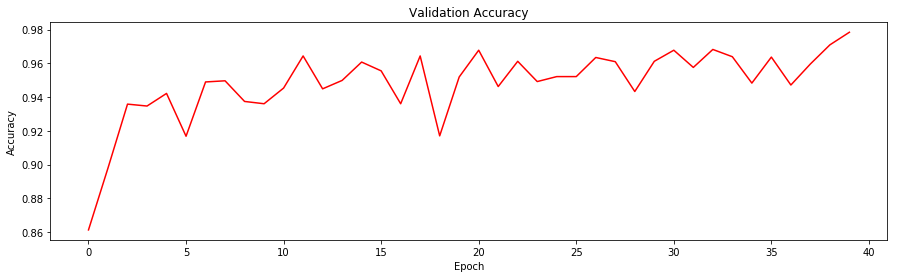

In [20]:
        
# Plot Validatioon accuracy_history
plt.rcParams["figure.figsize"] = (15,4)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(accuracy_history, 'r')  # validation accuracy

plt.rcParams["figure.figsize"] = (15,5)
plt.savefig(os.path.join(examplepath, "4_ValidationAccuracy.png"), dpi=600)

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [21]:
## Test
with tf.Session() as sess:
    saver.restore(sess, MODEL_PATH)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from tfmodel/My2.ckpt
Test Accuracy = 0.941


---

## Step 3: Test a Model on New Images



### Load and Output the Images

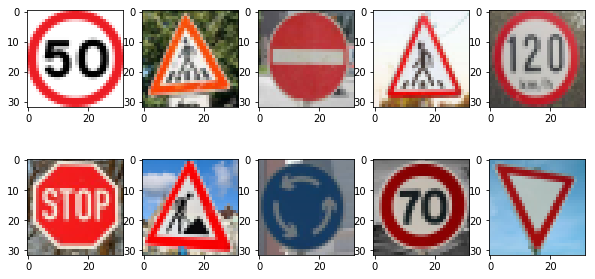

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

eimages = []
image_files  = ['examples/' + image_file for image_file in os.listdir('examples')]
nimage = len(image_files)
plt.rcParams["figure.figsize"] = (10,5)
i=0
for image_file in image_files:
    im = cv.imread(image_file)
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB) # To RGB
    height, width = im.shape[:2]
    im = cv.resize(im, (32, 32), interpolation = cv.INTER_AREA)
    #plt.figure()
    plt.subplot(math.ceil(nimage/5), 5, i+1)
    plt.imshow(im)
    eimages.append(im)
    i +=1
    
plt.rcParams["figure.figsize"] = (15,5)
plt.savefig(os.path.join(examplepath, "5_SignsFromWeb.png"), dpi=600)

n_eimage = i


In [23]:
# Load signnames.csv for sign label
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue
        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)
        label_map[label_int] = label_string
#label_map

### Predict the Sign Type for Each Image

In [24]:

x_ex = preprocess(eimages, grayscale)

with tf.Session() as sess:
    saver.restore(sess, MODEL_PATH)    
    predictions = sess.run(predicted_operation, feed_dict={x: x_ex})

final_preds = [label_map[pred] for pred in predictions]

# Print predictions 
for i in range(n_eimage):
    print('%s --> %s' % (image_files[i], final_preds[i]))

INFO:tensorflow:Restoring parameters from tfmodel/My2.ckpt
examples/sign1.png --> Children crossing

examples/sign10.png --> General caution

examples/sign2.png --> No entry

examples/sign3.png --> General caution

examples/sign4.png --> Roundabout mandatory

examples/sign5.png --> Stop

examples/sign6.png --> Road work

examples/sign7.png --> Roundabout mandatory

examples/sign8.png --> Speed limit (70km/h)

examples/sign9.png --> Yield



### Analyze Performance

#### Accuracy for these 10 new images.
* sign1: wrong. Speed limit 50 as Children crossing
* sign10: wrong. Pedestrian crossing as general caution
* sign2: right. No entry
* sign3: wrong. Pedestrian crossing as general caution
* sign4: wrong. Speed limit 120 as roundabout mandatory
* sign5: rignt. Stop
* sign6: right. Road work
* sign7: right. Roundabout mandatory
* sign8: right. speed limit 70 
* sign9: right. Yield


Out of the 10 signs, 6 are predicted correctly. The model achieve performance 60%
The 2 signs for pedestrian crossing are all misspredicted.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [25]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, MODEL_PATH)
    
    predictions, probs = sess.run(
        [predicted_operation, tf.nn.top_k(tf.nn.softmax(logits), k=5)],
        feed_dict={x: x_ex})
    

# Print predictions 
for i in range(len(predictions)):
    print('%s --> %s' % (predictions[i], probs.values[i]))


INFO:tensorflow:Restoring parameters from tfmodel/My2.ckpt
28 --> [9.9999928e-01 7.2024005e-07 3.6727977e-12 6.7069299e-13 1.4098661e-13]
18 --> [9.9974102e-01 2.5689884e-04 2.0036687e-06 7.2187256e-09 3.7400841e-10]
17 --> [1.000000e+00 9.506732e-20 6.518231e-23 5.527943e-23 2.847786e-25]
18 --> [0.8756573  0.0674255  0.04732626 0.0086319  0.00091004]
40 --> [7.3885655e-01 2.1818408e-01 4.2041183e-02 5.6607992e-04 3.2989468e-04]
14 --> [1.0000000e+00 3.0015321e-19 1.3218541e-19 5.1646014e-20 3.7274655e-20]
25 --> [1.0000000e+00 3.7863995e-33 6.7678737e-35 2.2274603e-36 0.0000000e+00]
40 --> [1.0000000e+00 4.1207113e-10 7.3074752e-14 4.4235174e-14 3.4916965e-14]
4 --> [1.0000000e+00 2.0706099e-17 6.8943622e-19 1.1328134e-19 1.2673392e-22]
13 --> [1. 0. 0. 0. 0.]


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.